# Milestone 2 pipeline

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive




## General scheme
The pipeline for Milestone 2 (and therefore M3 as well) is generally described by the following scheme:

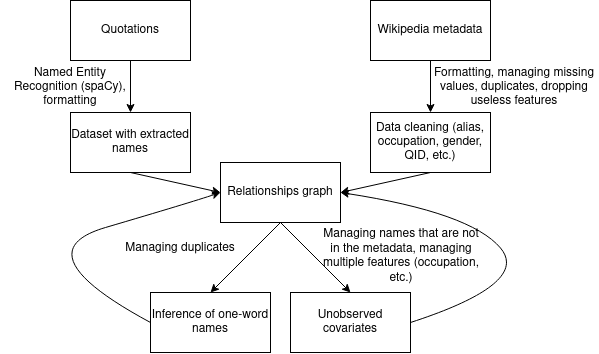

In [3]:
from IPython.display import Image
Image('/content/drive/MyDrive/scheme.png')

## Meta Data extraction and cleaning
In this part, the meta data (features about the speakers, around 9M entries) is prepared to be joined with the names extracted from the quotations afterwards.

### Meta Data loading
We won't need to load all columns, as we mostly care about the **occupation** and **gender**. As this dataset isn't so large originally and we don't every load column, loading all of it at once is not an issue. However, the exploded views will contain a lot more entries, so we'll need to process those chunk per chunk.

In [4]:
# loads the meta data
import bz2
import json
import pandas as pd

# it runs for ~2 mins
meta = pd.read_parquet('/content/drive/MyDrive/Project datasets/speaker_attributes.parquet',
                       columns=['aliases', 'label', 'occupation', 'gender'])
print(f"Loaded data about {meta.shape[0]} speakers")
meta.head()

Loaded data about 9055981 speakers


,aliases,label,occupation,gender
0,"[Washington, President Washington, G. Washingt...",George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",Douglas Adams,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",[Q6581097]
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",Paul Otlet,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",[Q6581097]
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",George W. Bush,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q6581097]
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",Diego Velázquez,[Q1028181],[Q6581097]


### Preprocessing the gender
At some point the dataset will be exploded according to the aliases, which will multiply the number of entries. Therefore, it is preferable to do as much preprocessing as possible before, including dealing with the gender.

#### What does the 'gender' feature look like ?

It must be noted that 'gender' is actually a list when it is not None. We can check the number of genders on average for each entry:

In [5]:
def average_number_of_items(data, column):
  """
  Computes the average number of items in a column whose values are lists or
  None. Counts "None" as one value.
  """
  return data[column].apply(lambda x: len(x) if x is not None else 1).mean()

In [6]:
average_number_of_items(meta, 'gender')

1.0001533792970634

It appears that 0.015% of the entries include multiple genders. Therefore those
rows will not induce a bias in the graph as the occupations could (see below).

We can have a look at how the genders are distributed in the population to know
how many nodes in the graph the 'genre' feature would induce:

In [7]:
from collections import Counter

In [8]:
def count_occurences(series):
  """
  Counts the occurences of each value in a pd series
  whose elements are lists.
  """
  # Counts the occurences of each item that is at least in one
  # list
  cnt = Counter()
  def add_to_counter(items):
    if items is None:
      cnt["None"] += 1
    else:
      for item in items:
        cnt[item] += 1
  series.apply(add_to_counter)

  # Returns the result as a dataframe sorted in descending order
  df = pd.DataFrame({"occurences": cnt.values()}, index=cnt.keys())
  return df.sort_values(by='occurences', ascending=False)

In [9]:
gender_occurences = count_occurences(meta['gender'])
print(f'Found {gender_occurences.shape[0]} distinct genders')

Found 40 distinct genders


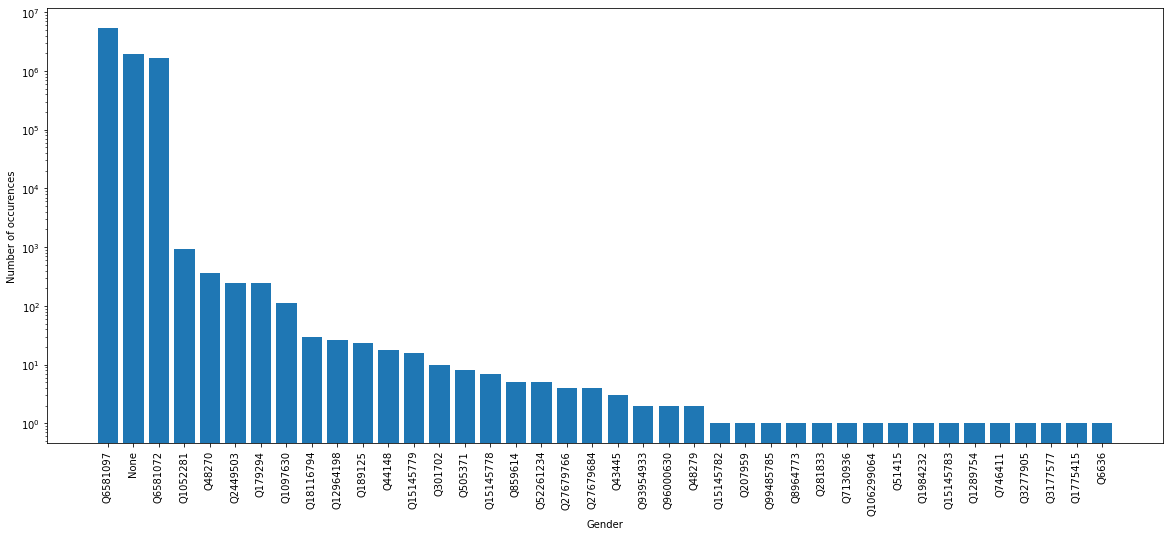

In [10]:
# Plots the occurences of each gender
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.set_xlabel("Gender")
ax.bar(np.arange(gender_occurences.shape[0]), gender_occurences['occurences'])
ax.set_ylabel("Number of occurences")
ax.set_yscale('log')
ax.set_xticks(np.arange(gender_occurences.shape[0]))
ax.set_xticklabels(gender_occurences.index, rotation=90)
fig.show()

Note that we don't need to know the names of the genders for now so we stick to the QIDs. The human-readable names will be retrieved later in the pipeline.

Conclusion: we found 40 distinct genders, which is *a priori* not too many to be used to split the people into groups. On the other hand, most of the genders only appear one, a few times or a few tens of times. As **we want to avoid very small groups** (such as one or two people), it will probably be better to **create a category for those extremely rare genres**.

### Preprocessing the occupation
Similarly to the gender, the occupation is actually a list of Wikidata entity ids. There are several ways we can go about it:
* 1 - Keep all occupations. This could generate a bias as a single person could generate links between multiple nodes in the graph when they are a speaker or are mentioned in a quotation. For example, if "Barack Obama" mentions a person P, this will create a link from all of B.Obama's occupations to P's occupation. This would include occupations one would not think of, such as "political writer" that are in fact nowhere related to the content of the quotation. However, we need to split the people in a way so that groups are not to small. If for example every person had a unique occupation, then we would find ourselves with a node in the graph for every person !

* 2 - Select a single occupation for each person. For example, the occupations on Wikipedia are sorted according to their importance / relevance (Barack Obama is reffered to as 'politician', then 'lawyer' before 'political writer'). It would therefore make sense to use only the first occupation. However this can also create a bias since some occupations could by nature not in general be a main occupation (which is the case of 'political writer'). Nonetheless if the first occupation is on average very specific and only includes a few individuals, then we *again* find ourselves with a too sharp splitting.

* 3- Selecting a set of occupations based on their repartition in the data. This would solve the problem of splitting the speakers into large groups, as we could keep for example only the 100 most represented occupations. However we loose the information regarding the least represented occupations, which could have be interesting for the analysis in the end. One way to solve this issue to is to select the most represented occupations and create an 'other' category, just like for the gender. This 'other' category could actually be several 'other' categories, in which the occupations are matched together by similarity.

* 4 - A mix of (1) and (3): we first build the graph with all occupations. Let's ignore the gender here for simplification. As each node corresponds to a single occupation, we obtain a graph with as many nodes as distinct occupations in the meta data. We then **group the graph nodes together based on their proximity**. Let G1, G2 be a pair of very small groups, then if G1 and G2 are linked or are linked to another large group, then G1 and G2 are merged into a new larger group. This method is more computationally expensive as we need to build the graph with all occupations, but lets us adjust the sizes of the nodes as we can merge groups together until they're large enough. The main downside is that we might merge groups that should remain separated (for example, 'pornographic actor' and 'researcher') if we're not careful.

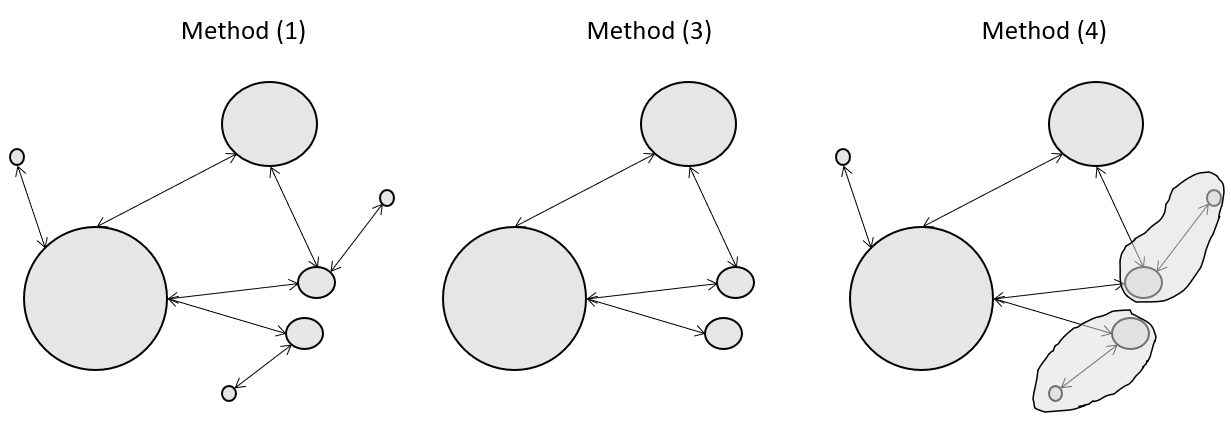

In [11]:
Image('/content/drive/MyDrive/pictures/occupations_methods.PNG')


In order to get an idea of which method best suits our need, we need more details about the 'occupation' feature.
We can have a look at the distribution of the number of occupations per person:

In [12]:
# Counts the number of occupations in each entry, counting None as 0
nb_occupations = meta['occupation'].apply(lambda x: len(x) if x is not None else 0)
nb_occupations.describe()

count    9.055981e+06
mean     9.209621e-01
std      8.756128e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.300000e+01
Name: occupation, dtype: float64

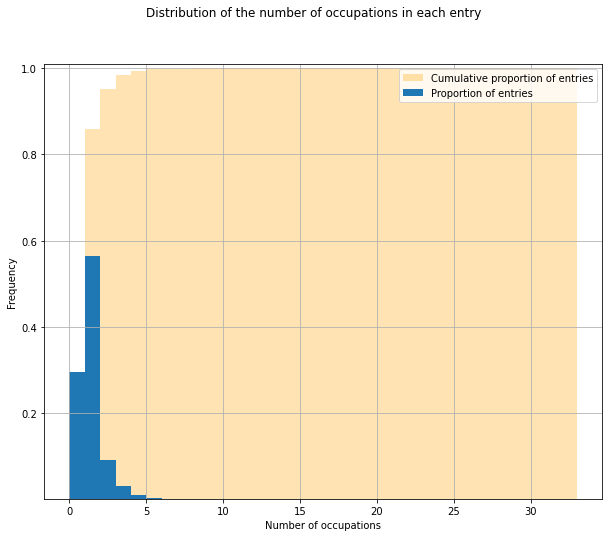

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
nb_occupations.hist(bins=33, ax=ax, cumulative=True, density=True,
                    color="orange", alpha=0.3)
nb_occupations.hist(bins=33, ax=ax, density=True)
ax.set_xlabel("Number of occupations")
ax.set_ylabel("Frequency")
ax.set_ylim([0.001, 1.01])
ax.legend(['Cumulative proportion of entries', 'Proportion of entries'],
          loc="upper right")
fig.suptitle("Distribution of the number of occupations in each entry")
fig.show()

We conclude that:
* On average the entries have less than 1 occupation (because of the ~$1.5* 10^6$ None values, which represent at least 25% of the dataset);
* About 55% of the entries have a single occupation, and about 15% have multiple occupations.
* Entries with more than 5 occupations are exceptional.

As mentioned, a crucial point is the distribution of the *number of occurences* of the occupations. We need to know how specific the occupations are: if each occupation only corresponds to 1 or 2 speakers then the feature cannot be used to group people, as it would create too many groups.

In [14]:
# Counts the number of occurences of each occupation
occupations_count = count_occurences(meta['occupation'])

In [15]:
print(f'Found {occupations_count.shape[0]} distinct occupations (ignoring None)')
occupations_count.head(10)

Found 14576 distinct occupations (ignoring None)


,occurences
None,2682897
Q1650915,1694140
Q82955,658049
Q937857,317958
Q33999,281266
Q36180,278888
Q1028181,169246
Q3665646,133601
Q1930187,128913
Q1622272,119861


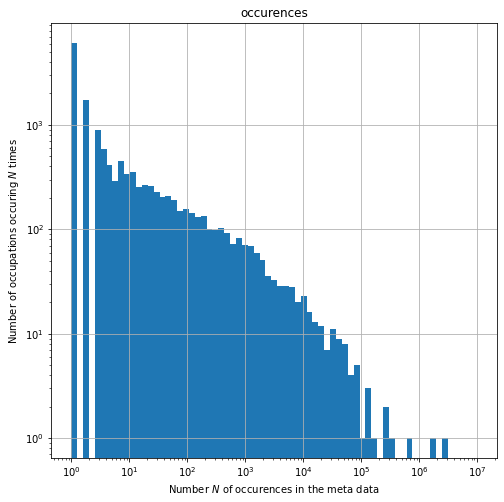

In [16]:
# Plots the distribution of the number of occurences of the occupations
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
logbins = np.logspace(0, 7, 70)
occupations_count.hist(ax=ax, log=True, bins=logbins)
ax.set_xscale('log')
ax.set_xlabel("Number $N$ of occurences in the meta data")
ax.set_ylabel("Number of occupations occuring $N$ times")
fig.show()

The meta data contain 14 575 occupations for 9M entries if the entries with None occupations are ignored. While this still makes more than 600 people per occupation on average, we can't afford to create a graph with 14 000 nodes.

However it appears that a tiny proportion of the occupations includes those that appear the most in the meta data. This lets us think that method (3) can be suited to our objective. For instance, selecting only the occupations that appear at least 10 times yields less than a hundred occupations instead of 14 500 !

### Exploding according to the aliases
We'll use the aliases to match the names extracted from the quotations:

In [17]:
meta = meta.explode('aliases')
meta.head()

,aliases,label,occupation,gender
0,Washington,George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]
0,President Washington,George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]
0,G. Washington,George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]
0,Father of the United States,George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]
0,The American Fabius,George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]


## Referred names in quotations
In this part, we extract referred names from quotations with spaCy and we do some analysis on the obtained distribution.

### Name extraction with spaCy


In [18]:
import csv
import bz2
import json
import en_core_web_sm
import pandas
import matplotlib.pyplot as plt
import itertools
import re
import random
import seaborn as sns
import numpy as np

from collections import Counter

We perform Named Entity Recognition using spaCy's library. We fix the size at 100 000 samples as it takes around 2 hours to generate it. Note that, as the size of Quotebank's datasets are large, we don't care about sampling with or without replacement, as variances for both are the same in average. CSV files generated are composed of 3 features: quoteID (id of the quotation), *subject* (referred person) and *speaker* (Quotebank's speakers).

In [19]:
# Samples we extract
MAX_SAMPLES = 100000
STEP_PROGRESS = MAX_SAMPLES / 10

# https://spacy.io/models/en
nlp = en_core_web_sm.load()

def init_csv(output_filename):
  """
  Init CSV file with header
  subject is a new feature corresponding 
  to the referred person
  """
  header = ['quoteID', 'subject', 'speaker']
  with open(output_filename, 'w') as output_file:
    writer = csv.writer(output_file)
    writer.writerow(header)
        
def write_to_csv(output_filename, samples):
  """
  Write to CSV file samples which have been extracted
  """
  with open(output_filename, 'a') as output_file:
    writer = csv.writer(output_file)
    for sample in samples:
      writer.writerow(sample)
            
def construct_name_feature(filename, output_filename):
  """
  Parse Quotebank's dataset and extract names with spaCy
  Processing and writting to CSV file are done on the fly
  to avoid overloading the RAM memory
  """
  nb_samples = 0
  samples = []
  limit_progress = STEP_PROGRESS
  perc_progress = 10
  
  with bz2.open(filename, "rt") as file:

    # Browse each row in Quotebank's dataset
    for i, row in enumerate(file):
          
      # Write in the CSV file 10 000 samples retrieved
      # to avoid overloading the RAM memory
      if i % 10000 == 0:
        write_to_csv(output_filename, samples)
        samples = []

      # Tokenize a row with spaCy
      sample = json.loads(row)
      sample_tokens = nlp(sample['quotation'])
      for x in sample_tokens.ents:
        # None speakers are not considered in our problem
        if x.label_ == 'PERSON' and sample['speaker'] != 'None':
          samples.append(
            [sample['quoteID'], x.text, sample['speaker']]
          )
          nb_samples += 1
          
      # Progression of processing
      if (nb_samples >= limit_progress):
        print('{}% name couples have been obtained for {}.'.format(perc_progress, output_filename))
        limit_progress += STEP_PROGRESS
        perc_progress += 10
          
      # Exit condition
      if (nb_samples >= MAX_SAMPLES):
        break
              
    # Write the last obtained samples
    write_to_csv(output_filename, samples)

Let's generate our datasets with 100 000 samples for each year of Quotebank's datasets. The boolean below has to be settled to True if you want to generate them (note: you have time to watch the Lord of the Rings trilogy 😀).


In [20]:
# The generation of a dataset for 100 000 samples is about 2 hours
# Set DO_EXTRACTION boolean to True if you want to generate them
DO_EXTRACTION = False

if (DO_EXTRACTION):

  # Quotebank's datasets
  filenames = ['/content/drive/MyDrive/Quotebank/quotes-2015.json.bz2', '/content/drive/MyDrive/Quotebank/quotes-2016.json.bz2', '/content/drive/MyDrive/Quotebank/quotes-2017.json.bz2',
                '/content/drive/MyDrive/Quotebank/quotes-2018.json.bz2', '/content/drive/MyDrive/Quotebank/quotes-2019.json.bz2', '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2']

  # CSV files with extracted names
  output_filenames = ['/content/drive/MyDrive/OwnData/quotes-2015-subjects.csv', '/content/drive/MyDrive/OwnData/quotes-2016-subjects.csv', '/content/drive/MyDrive/OwnData/quotes-2017-subjects.csv',
                      '/content/drive/MyDrive/OwnData/quotes-2018-subjects.csv', '/content/drive/MyDrive/OwnData/quotes-2019-subjects.csv', '/content/drive/MyDrive/OwnData/quotes-2020-subjects.csv']

  # Init CSV files
  for output_filename in output_filenames:
    init_csv(output_filename)
    print('File {} initialized.'.format(output_filename))

  # Extract names from Quotebank's datasets
  for filename, output_filename in zip(filenames, output_filenames):
    construct_name_feature(filename, output_filename)
    print('File {} processes.'.format(filename))

### Extracted names distribution

CSV files have been zipped post-generation. 

In [21]:
years = ['2015', '2016', '2017', '2018', '2019', '2020']

zipped_filenames = ['/content/drive/MyDrive/OwnData/quotes-2015-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2016-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2017-subjects.csv.zip',
                    '/content/drive/MyDrive/OwnData/quotes-2018-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2019-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2020-subjects.csv.zip']

dfs = [pd.read_csv(filename, compression='zip') for filename in zipped_filenames]
# It has been discovered that quotations can be duplicated in Quotebank's datasets, we remove them for now
# Watchout: some quotes can appear twices because they contain several names !
# Therefore we should remove the duplicates based on the quoteID AND the subject
dfs = [df.drop_duplicates(subset=['quoteID', 'subject'], keep='first', inplace=False) for df in dfs] 

In [22]:
dfs[0].head(10)

,quoteID,subject,speaker
0,2015-06-18-018819,Donald Trump,Chris Matthews
1,2015-09-16-000331,Jason,Jordan Spieth
2,2015-09-16-000331,Rickie,Jordan Spieth
3,2015-10-25-000242,Clinton,Bernie Sanders
4,2015-04-25-012511,Howard,Rick Carlisle
5,2015-10-04-014109,Trafford,Michael Owen
6,2015-10-02-000466,Miller,Norv Turner
7,2015-07-14-000994,Steven Universe,Rebecca Sugar
8,2015-07-14-000994,Steven,Rebecca Sugar
9,2015-11-17-031545,Sanjay Dutt,Dawood Ibrahim


In [23]:
def get_possessive_names(df):
  """
  Get all names which end with possessive form
  Example: Adrien's ends with a possessive form
  """
  possessive_names = []
  for name in df['subject']:
    x = re.search("^[a-zA-Z ]+'s$", name)
    # We have found a possessive form
    if x is not None:
      possessive_names.append(name)
  return possessive_names

def get_bad_names(df):
  """
  Get all names which contain characters as parentheses,
  slashes, brackets, etc. They are not valid names
  """
  bad_names = []
  for name in df['subject']:
    x = re.search("^[a-zA-Z ]+['s]*", name)
    # We have found a bad name
    if x is None:
      bad_names.append(name)
  return bad_names

possessive_names_dfs = [get_possessive_names(df) for df in dfs]
bad_names_dfs = [get_bad_names(df) for df in dfs]

for i in range(len(years)):
  print('Year {}: [possessive_names={},bad_names={}]'.format(years[i], len(possessive_names_dfs[i]), len(bad_names_dfs[i])))

Year 2015: [possessive_names=1899,bad_names=393]
Year 2016: [possessive_names=1919,bad_names=485]
Year 2017: [possessive_names=1848,bad_names=506]
Year 2018: [possessive_names=1767,bad_names=536]
Year 2019: [possessive_names=1914,bad_names=638]
Year 2020: [possessive_names=1791,bad_names=661]


As we can see, the names ending with a possessive form, i.e., ending with the pattern *'s are rather present (about 1.5% of the whole dataset). These names can be kept by removing this pattern. Now, 0.05% of each dataset seems unusable as names contain unusual characters such as parentheses, brackets or slashes. As a result, we'll be able to remove all these characters to try to keep some names (note: these are spaCy mistakes).

In [24]:
# Computes the number of words in each name, for each year, for subjects and speakers
sizes_names_subjects = [df['subject'].str.split().str.len().value_counts() for df in dfs]
sizes_names_speakers = [df['speaker'].str.split().str.len().value_counts() for df in dfs]

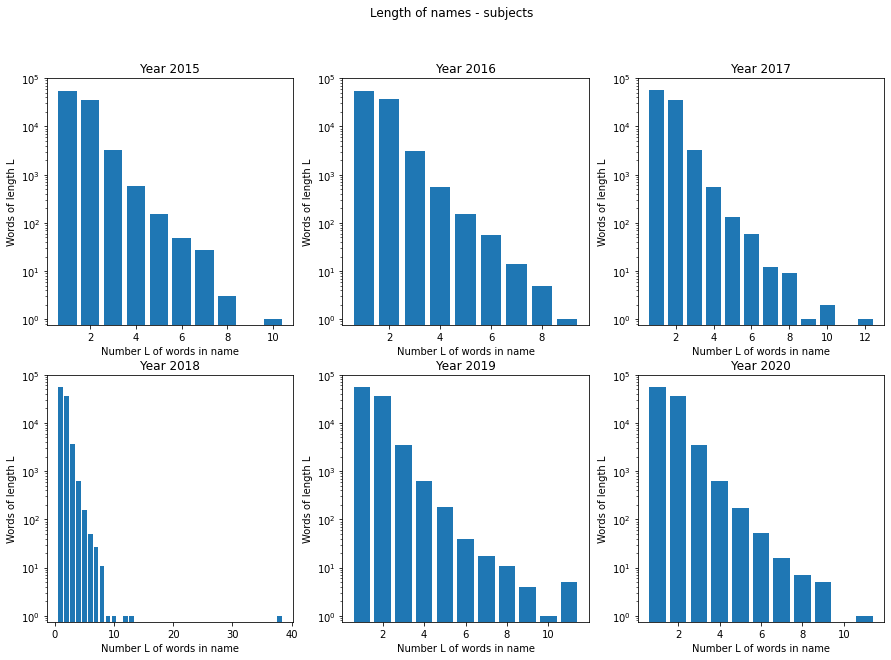

In [25]:
def plot_sizes(sizes):
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
  for i, size in enumerate(sizes):
    ax = axes[i // 3, i % 3]
    ax.bar(size.index, size.values)
    ax.set_yscale('log')
    ax.set_ylabel("Words of length L")
    ax.set_xlabel("Number L of words in name")
    ax.set_title("Year {}".format(2015 + i))
    ax.set_ylim(0.75, 1e5)
  return fig

fig = plot_sizes(sizes_names_subjects)
fig.suptitle("Length of names - subjects")
fig.show()

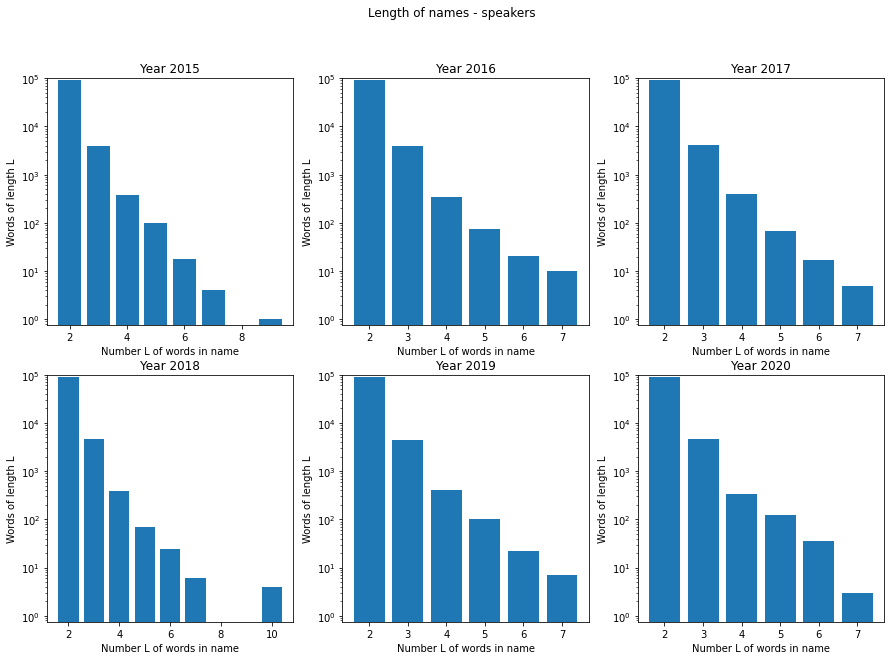

In [26]:
fig = plot_sizes(sizes_names_speakers)
fig.suptitle("Length of names - speakers")
fig.show()

The bar charts above show the number of words for each name in each of our datasets (each year). We can see that for the majority of the extracted referred persons, all the names are composed of a single word (first or last name). This *can* be a problem that we should have to address. Otherwise, other names consist of two words. Also, distributions between each year are almost identical (note the year 2018 where the x-scale is off due to an outlier with a name with 40 words, this should be a spaCy error). For speakers, distributions are also equivalent and this time, we notice that all the names are mainly composed of two words. 

In [27]:
def get_count_duplicates(df):
  """
  Group rows that are duplicated and count them
  """
  # Group rows of subject feature (extracted names)
  duplicates = df.loc[df['subject'].duplicated(keep=False)] \
                .groupby('subject') \
                .agg({'subject': 'count'}) \
                .rename(columns={'subject': 'subject_count'}) \
                .sort_values(by='subject_count', ascending=False) \
                .reset_index()

  return duplicates

# Contains the counts of each name that appears multiple times,
# for each year
duplicates_dfs = [get_count_duplicates(df) for df in dfs]

In [28]:
def plot_recurrent_names(names_counts):
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,13), tight_layout=True)
  for i, names_count in enumerate(names_counts):
    # Retrieves the name and the occurences count
    names = names_count.iloc[:20, 0]
    counts = names_count.iloc[:20, 1]

    ax = axes[i // 3, i % 3]
    ticks = np.arange(names.shape[0])
    ax.bar(ticks, counts)

    ax.set_xticks(ticks)
    ax.set_xticklabels(names, rotation=90)
    ax.set_ylabel("Number of mentions in quotations")
    ax.set_xlabel("Subject name")
    ax.set_title("Year {}".format(2015 + i))
    ax.set_ylim(0, 1650)
  return fig

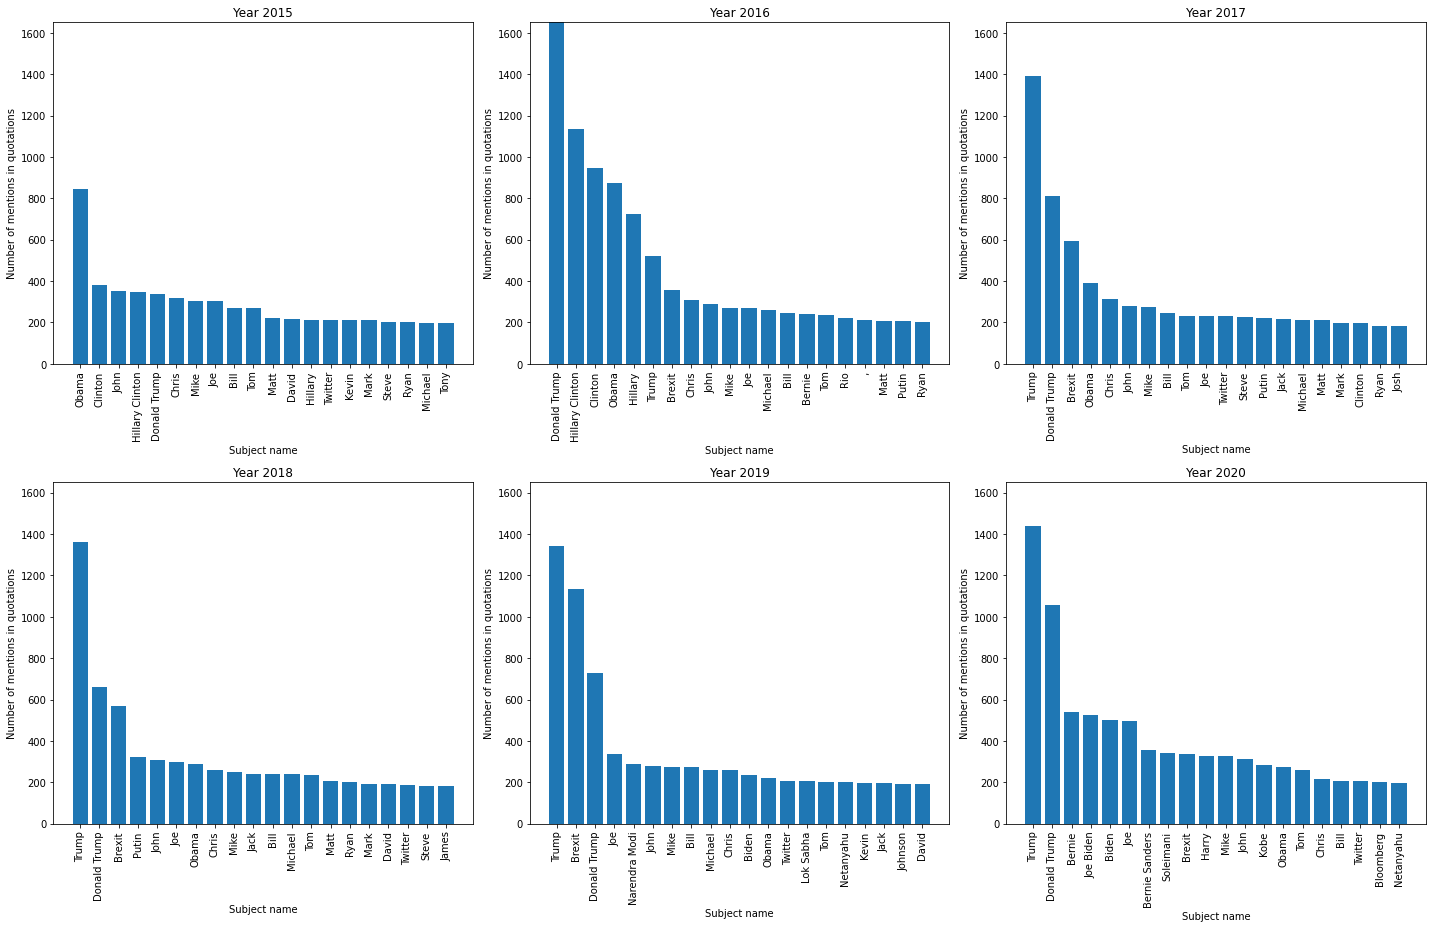

In [29]:
fig = plot_recurrent_names(duplicates_dfs)
fig.show()

The above data represents the number of times a name appears in the extracted referred persons. It's pretty much distributed in the same way (always people from the political sphere in the lead), but there is... Brexit !? It seems to be a spaCy mistake which should not be a big problem for us because Brexit should not be present in the metadata, so it will be thrown away. Note that political figures often appear with one or two words in their names (as "Hillary", "Clinton" and "Hillary Clinton" in 2016).

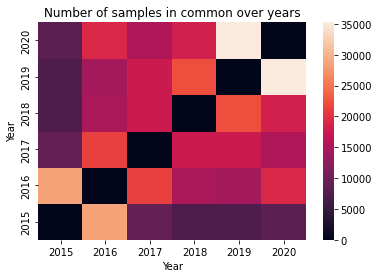

In [30]:
# Get samples which are in common over years
commons_samples_sizes = np.array([[0 for _ in range(6)] for _ in range(6)])
for ((i_1, df_1), (i_2, df_2)) in itertools.combinations(enumerate(dfs), 2):
  # Store the number of samples in a matrix
  commons_samples_sizes[i_1, i_2] = len(df_1.merge(df_2, on=['subject', 'speaker'], how='inner').index)
  commons_samples_sizes[i_2, i_1] = commons_samples_sizes[i_1, i_2]

# Plot a heatmap (we force to 0 on the diagonal as years are identical)
ax = sns.heatmap(commons_samples_sizes, xticklabels=years, yticklabels=years)
ax.invert_yaxis()
plt.xlabel('Year')
plt.ylabel('Year')
plt.title('Number of samples in common over years')
plt.show()

The matrix above shows the number of pairs (subject, speaker) in common for each years pair. We can note that it is very interesting, because the distribution does not seem uniformly distributed, affirming our choice to work on the evolution of relationships over the years. In particular, we can see that the number of couples in common is greatest for two consecutive years, which seems reasonable as people are more likely to be in short-term relationships. Another reason could be that many people have relationships at the end of the year and the beginning of the next year. Perhaps, it should be more interesting to reason in terms of months rather than years to be more precise.

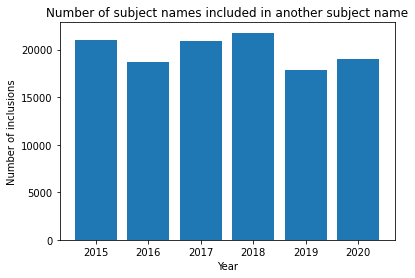

In [31]:
def is_included(name_1, name_2):
    """
    Returns true if name_1 is included in name_2
    """
    return name_1 in name_2

def construct_included_names(names_1, names_2):
  """
  Check for each x in names_1 (resp. names_2) 
  if x is included in names_2 (resp. names_1)
  """
  included_names = []
  
  for first_name, second_name in itertools.product(names_1, names_2):
    # If name sizes are not the same, we don't consider it
    if len(first_name) != len(second_name) and is_included(first_name, second_name) or is_included(second_name, first_name):
      
      string_first_name = ' '.join(first_name)
      string_second_name = ' '.join(second_name)
      included_names.append((string_first_name, string_second_name))
              
  # We only want to know the unique pairs
  included_names = set(included_names)
  return (len(included_names), included_names)

# Generate 10 000 samples from extracted names distribution
# Note: we reduce the problem because of combinatorial explosion
nb_rows = 100000
sample_size = 10000

reduced_dfs = []
for i, filename in enumerate(zipped_filenames):
    # Get a permutation
    skip = sorted(random.sample(range(1, nb_rows + 1), nb_rows - sample_size))
    # Read CSV files and skip rows that are not in the permutation
    reduced_df = pandas.read_csv(filename, skiprows=skip, compression='zip')
    # Drop duplicates
    reduced_df.drop_duplicates(subset=['quoteID'], keep='first', inplace=True)
    reduced_dfs.append(reduced_df)

# Get included names for each year
included_names_dfs = [construct_included_names(reduced_df['subject'].tolist(), reduced_df['subject'].tolist()) for reduced_df in reduced_dfs]

# Plot a bar chart
plt.bar(years, [x[0] for x in included_names_dfs])
plt.xlabel("Year")
plt.ylabel("Number of inclusions")
plt.title("Number of subject names included in another subject name")
plt.show()

The bar chart above shows the distribution of names that are included in others. As an example, "Hillary" is included in "Hillary Clinton" and we are interested to know if this distribution is large. Note that the couples have been counted only once and what we can see is that the distribution is quite identical for each year. Also, we have only considered the referred people that we have extracted, it might be interesting to try if subjects are included in speakers, which is likely to be strongly the case. It is very good to get these results because it promotes our work that some of the obtained names can be inferred from the relationships between each person (Milestone 3 here we come!).

## Match Meta Data with the database extracted from spaCy

In this part, we modify to meta data to get labels instead of QID's for both gender and occupation. We also merge the obtained explicit meta data with the data extracted with spaCy.

### Replacing the meta data QIDs with actual values

For now, if multiple individuals have the same alias we have no way to identify which is the real individual. So we drop all duplicates. Note that this could be improved later. 

In [32]:
meta.drop_duplicates(subset=["aliases"], keep=False, inplace=True)

Now we preprocess the meta data as before to get gender and occupation.

In [33]:
meta = meta.explode("gender")
meta = meta.explode("occupation")

At that point each key (aliases, occupation, gender) is unique. So we replace the QID's for the occupation and the gender by their Labels (for example "Q15077007" by "podcaster").

We load the file wikidata_labels_descriptions_quotebank.csv.bz2.

In [34]:
wiki = pd.read_csv('/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2')

And we replace the occupation column with QID's by a new occupation column with labels.

In [35]:
explicit_meta = meta.merge(wiki, left_on="occupation", right_on="QID", how="inner")
explicit_meta.drop(["occupation", "Description"], inplace=True, axis=1)
explicit_meta.rename(columns={"Label": "occupation"}, inplace=True)

In [36]:
print(explicit_meta.shape)
explicit_meta.head()

(2449963, 5)


,aliases,label,gender,QID,occupation
0,President Washington,George Washington,Q6581097,Q82955,politician
1,Father of the United States,George Washington,Q6581097,Q82955,politician
2,The American Fabius,George Washington,Q6581097,Q82955,politician
3,George Walker Bush,George W. Bush,Q6581097,Q82955,politician
4,Bush Jr.,George W. Bush,Q6581097,Q82955,politician


We remark that for one of the occupations of María del Socorro Gutiérrez Martínez the QID occupation is labeled as NaN. This is because this occupation is labeled as NaN in the wikidata: 

In [37]:
wiki[wiki["QID"] == "Q2496362"]

,QID,Label,Description
34038,Q2496362,NaN,NaN


By sending a query to the Wiki Database we see that actually this ID is not associated to any label.

In [38]:
!pip install qwikidata
from qwikidata.sparql  import return_sparql_query_results

In [39]:
def get_wiki_label(item):
  query_string = """PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
  PREFIX wd: <http://www.wikidata.org/entity/> 
  select  *
  where {
        wd:%s rdfs:label ?label .
  FILTER (langMatches( lang(?label), "EN" ) )
      } 
  LIMIT 1""" % item
  res = return_sparql_query_results(query_string)

In [40]:
res = get_wiki_label("Q2496362")
print("Associated label : ", res)

Associated label :  None


In [41]:
explicit_meta.drop(["QID"], inplace=True, axis=1)

We do the same for gender.

In [42]:
explicit_meta = explicit_meta.merge(wiki, left_on="gender", right_on="QID", how="inner")
explicit_meta.drop(["gender", "Description", "QID"], inplace=True, axis=1)
explicit_meta.rename(columns={"Label": "gender"}, inplace=True)

We get the final dataset with the meta data explicitely written.

In [43]:
print(explicit_meta.shape)
explicit_meta.head()

(2317927, 4)


,aliases,label,occupation,gender
0,President Washington,George Washington,politician,male
1,Father of the United States,George Washington,politician,male
2,The American Fabius,George Washington,politician,male
3,George Walker Bush,George W. Bush,politician,male
4,Bush Jr.,George W. Bush,politician,male


### Merging meta data with spaCy data
The following loads the extracted names after they have been **inferred** (See Milestone 3 - Infer names). For practical purposes, this needs to be inserted here.

In [ ]:
years = ['2015', '2016', '2017', '2018', '2019', '2020']

zipped_filenames = ['/content/drive/MyDrive/OwnData/inferred-2015-subjects.csv', '/content/drive/MyDrive/OwnData/inferred-2016-subjects.csv', '/content/drive/MyDrive/OwnData/inferred-2017-subjects.csv',
                    '/content/drive/MyDrive/OwnData/inferred-2018-subjects.csv', '/content/drive/MyDrive/OwnData/inferred-2019-subjects.csv', '/content/drive/MyDrive/OwnData/inferred-2020-subjects.csv']

dfs = [pd.read_csv(filename) for filename in zipped_filenames]
# It has been discovered that quotations can be duplicated in Quotebank's datasets, we remove them for now
# Watchout: some quotes can appear twices because they contain several names !
# Therefore we should remove the duplicates based on the quoteID AND the subject
dfs = [df.drop_duplicates(subset=['quoteID', 'subject'], keep='first', inplace=False) for df in dfs]
dfs = [df.drop(columns=['Unnamed: 0']) for df in dfs]

We check that we can actually merge the spaCy dataset with the meta dataset to get information on both the speakers and the subjects. We also want to know if after the merging we still have enough data.

#### How much data can we get?

We merge the two datasets on speakers and aliases and on speakers and labels. At that point the key (quoteID, gender, occupation) is unique.

In [ ]:
dfs_speakers = []
for df in dfs:
  new_df =  pd.concat([df.merge(explicit_meta, left_on="speaker", right_on="aliases", how="inner"), df.merge(explicit_meta, left_on="speaker", right_on="label", how="inner")])
  dfs_speakers.append(new_df)
print(dfs_speakers[0].shape)
dfs_speakers[0].head()

(463762, 7)


,quoteID,subject,speaker,aliases,label,occupation,gender
0,2015-08-23-016645,Reed Warbler,Robert Vaughan,Robert Vaughan,Robert M Vaughan,researcher,male
1,2015-08-23-016645,Blyth,Robert Vaughan,Robert Vaughan,Robert M Vaughan,researcher,male
2,2015-07-17-095979,Pittsfield,Robert Vaughan,Robert Vaughan,Robert M Vaughan,researcher,male
3,2015-10-23-033230,Chairman,Mike Mullen,Mike Mullen,Michael Mullen,military officer,male
4,2015-08-14-002835,Harper,Joe Oliver,Joe Oliver,King Oliver,songwriter,male


We do the same for subjects.

In [ ]:
dfs_subjects = []
for df in dfs:
  new_df =  pd.concat([df.merge(explicit_meta, left_on="subject", right_on="aliases", how="inner"), df.merge(explicit_meta, left_on="subject", right_on="label", how="inner")])
  dfs_subjects.append(new_df)

In [ ]:
print(dfs_subjects[0].shape)
dfs_subjects[0].head()

(380602, 7)


,quoteID,subject,speaker,aliases,label,occupation,gender
0,2015-08-23-016645,Blyth,Robert Vaughan,Blyth,Edward Blyth,zoologist,male
1,2015-08-23-016645,Blyth,Robert Vaughan,Blyth,Edward Blyth,naturalist,male
2,2015-08-23-016645,Blyth,Robert Vaughan,Blyth,Edward Blyth,curator,male
3,2015-08-23-016645,Blyth,Robert Vaughan,Blyth,Edward Blyth,ornithologist,male
4,2015-06-26-015938,Robbie,Gavin Reilly,Robbie,Alex Williamson,YouTuber,male


We check how many samples we have now for the subject and speaker databases. To do so we look at how many different quoteID's are left.

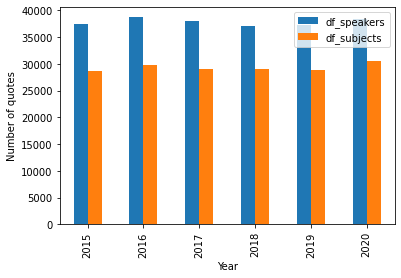

In [ ]:
import numpy as np

X = [2015, 2016, 2017, 2018, 2019, 2020]
Y1 = [len(df.drop_duplicates(subset="quoteID", keep="first")) \
      for df in dfs_speakers]
Y2 = [len(df.drop_duplicates(subset="quoteID", keep="first")) \
      for df in dfs_subjects]

df = pd.DataFrame(np.c_[Y1, Y2], index=X)
ax = df.plot(kind="bar", xlabel="Year", ylabel = "Number of quotes")
ax.legend(["df_speakers", "df_subjects"])

We still have a good number of quotes available. One can also remark that there are less remaining quotes for the subject dataset. This is probably due to fact that in the subject column there are a lot of one word names which are harder to identify. 

But as we lost half of the quotes we should check if this changed our data distribution. Alsoto improve the number of quotes we could think of an algorithm to identify the individuals which which are referred to with their first name only.

#### Merging issues

We remark that we have issues mostly with the subjects but also with the speakers which names are only one word long. Sometimes the subject is misidentified. Indeed you can't identify someone with his first name only. 

For example Hillary Clinton does not have "Hillary" in her aliases. And the only "Hillary" alias refers to Hillary Scott. Hence the alias "Hillary" is not a duplicate and not dropped. If we have a look at the following table we see that the Hillary subject is sometimes misidentified as Hillary Scott because of course President Barack Obama is definitely not speaking about Hillary Scott.

In [ ]:
dfs_subjects[0][dfs_subjects[0]["subject"] == "Hillary"]

,quoteID,subject,speaker,aliases,label,occupation,gender
4816,2015-08-05-029810,Hillary,Maggie Gallagher,Hillary,Hillary Scott,pornographic actor,female
4817,2015-03-07-040570,Hillary,President Barack Obama,Hillary,Hillary Scott,pornographic actor,female
4818,2015-02-04-003637,Hillary,Bill Kristol,Hillary,Hillary Scott,pornographic actor,female
4819,2015-12-29-086905,Hillary,Jo Ellen Litz,Hillary,Hillary Scott,pornographic actor,female
4820,2015-04-13-058729,Hillary,Reince Priebus,Hillary,Hillary Scott,pornographic actor,female
...,...,...,...,...,...,...,...
5023,2015-01-25-023456,Hillary,Julian Assange,Hillary,Hillary Scott,pornographic actor,female
5024,2015-09-01-047159,Hillary,Richard Manning,Hillary,Hillary Scott,pornographic actor,female
5025,2015-09-25-099357,Hillary,Steve Elmendorf,Hillary,Hillary Scott,pornographic actor,female
5026,2015-07-26-022487,Hillary,Donald Trump,Hillary,Hillary Scott,pornographic actor,female


In [ ]:
dfs_subjects[0][dfs_subjects[0]["gender"] == "genderfluid"]

,quoteID,subject,speaker,aliases,label,occupation,gender
23959,2015-08-03-091952,Hannah Montana,Courtney Love,Hannah Montana,Miley Cyrus,singer,genderfluid
23960,2015-08-03-091952,Hannah Montana,Courtney Love,Hannah Montana,Miley Cyrus,singer-songwriter,genderfluid
23961,2015-08-03-091952,Hannah Montana,Courtney Love,Hannah Montana,Miley Cyrus,musician,genderfluid
23962,2015-08-03-091952,Hannah Montana,Courtney Love,Hannah Montana,Miley Cyrus,actor,genderfluid
23963,2015-08-03-091952,Hannah Montana,Courtney Love,Hannah Montana,Miley Cyrus,film actor,genderfluid
...,...,...,...,...,...,...,...
251187,2015-02-16-065390,Miley Cyrus,Steve Martin,Miley R. Hemsworth,Miley Cyrus,voice actor,genderfluid
305423,2015-10-19-095734,Cara Delevingne,Jane Hill,Cara Jocelyn Delevingne,Cara Delevingne,singer,genderfluid
305424,2015-10-19-095734,Cara Delevingne,Jane Hill,Cara Jocelyn Delevingne,Cara Delevingne,actor,genderfluid
305425,2015-10-19-095734,Cara Delevingne,Jane Hill,Cara Jocelyn Delevingne,Cara Delevingne,film actor,genderfluid


# Milestone 3 - Building the graph and Analysis

## Assembling the final dataset
We need to build a dataset (quoteID, speaker, subject, speaker_occupation, subject_occupation, speaker_gender, subject_gender). We will refer to this dataset as the **mentions dataset**.

We can then build the graph with a simple loop:  
```
For each entry (QID, sp, su, spo, suo, spg, sug):
    Add nodes sp and su if they do not exist yet
    If there is an edge between nodes sp and su:
        Add 1 to the weight of that edge
    Else:
        Add a new edge from sp to su with weight 1
```
This creates a graph whose nodes are the names of people who are at least once speaker or subject (or both !). The edges weights indicate how many times each node ***mentioned*** its neighbours.  

Note that if we easily change the algorithm to have the nodes be the **occupations** or the gender instead.

In [ ]:
# There are actually one mention df for each year, from 2015 to 2020
mentions_dfs = [
             # We drop the 'aliases' and 'labels' columns as we don't
             # need those anymore
             pd.merge(df_spk.drop(['aliases', 'label'], axis=1),
                      df_sbj.drop(['aliases', 'label'], axis=1),
                      on=['quoteID', 'subject', 'speaker'],
                      suffixes=['_speaker', '_subject'])
             for df_spk, df_sbj in zip(dfs_speakers, dfs_subjects)
]

In [ ]:
print([df.shape for df in mentions_dfs])
mentions_dfs[0].head()

[(4698109, 7), (17905023, 7), (5382461, 7), (4207332, 7), (4060842, 7), (5400385, 7)]


,quoteID,subject,speaker,occupation_speaker,gender_speaker,occupation_subject,gender_subject
0,2015-08-23-016645,Blyth,Robert Vaughan,researcher,male,zoologist,male
1,2015-08-23-016645,Blyth,Robert Vaughan,researcher,male,naturalist,male
2,2015-08-23-016645,Blyth,Robert Vaughan,researcher,male,curator,male
3,2015-08-23-016645,Blyth,Robert Vaughan,researcher,male,ornithologist,male
4,2015-08-23-016645,Blyth,Robert Vaughan,novelist,male,zoologist,male


## Should we regroup the non-(male or female) genders ?
As seen during the data exploration, there could be up to 14 genders in the mentions datasets. We might not want to keep genders that only contain a single person, as it would get lost in the vast amount of nodes in the graph.

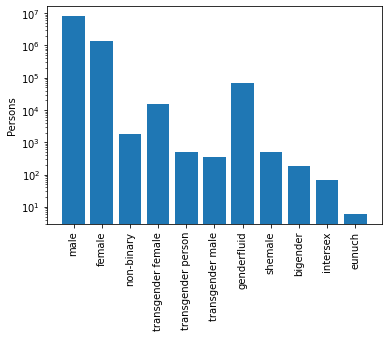

In [ ]:
# Retrieves the set of all genders that appear over all datasets
gender_counts = Counter()
for df in mentions_dfs[:1]:
  gender_counts += Counter(df['gender_speaker'])
  gender_counts += Counter(df['gender_subject'])
all_genders = list(gender_counts.keys())
counts = list(gender_counts.values())
plt.bar(np.arange(len(all_genders)), counts)
plt.yscale('log')
plt.xticks(np.arange(len(all_genders)), all_genders, rotation=90)
plt.ylabel("Persons")
plt.show()

All of the 14 genders that are present in the meta data are not linked to the quotations. None of them appears a single time (the minimum being "eunuch" which appears about 10 times). Therefore grouping the genders doesn't seem necessary.  
However, we've got "transgender male", "transgender female" but also "transgender person". Regrouping those into "transgender person" or "transgender" could be logical, but it doesn't feel right.

## Analysis of the data before the network

Number of speakers per year

In [ ]:
import plotly.graph_objects as go

year = ["2015", "2016", "2017", "2018", "2019", "2020"]

unique_speak_dfs = []
for df in mentions_dfs:
  unique_speak_dfs.append(df.drop_duplicates(subset=["speaker"]))

nb_m = []
nb_f = []
nb_o = []

for df in unique_speak_dfs:
    tot = len(df)
    nb1 = len(df[df["gender_speaker"] == "male"])
    nb_m.append(nb1)
    nb2 = len(df[df["gender_speaker"] == "female"])
    nb_f.append(nb2)
    nb_o.append(tot - nb1 - nb2)


fig = go.Figure(data=[
    go.Bar(name='Male', x=year, y=nb_m, text=nb_m,
            textposition='auto'),
    go.Bar(name='Female', x=year, y=nb_f, text=nb_f,
            textposition='auto'),
    go.Bar(name='Other', x=year, y=nb_o, text=nb_o,
            textposition='auto')
])

# Change the bar mode
fig.update_layout(barmode='stack', title="Gender of the different speakers")
fig.update_yaxes(title_text="Number of different speakers", type="log")
fig.update_xaxes(title_text="Year")
fig.show()

fig.write_html("Gender_speakers.html")

Number of subjects per year

In [ ]:
import plotly.graph_objects as go

year = ["2015", "2016", "2017", "2018", "2019", "2020"]

unique_sub_dfs = []
for df in mentions_dfs:
  unique_sub_dfs.append(df.drop_duplicates(subset=["subject"]))

nb_m = []
nb_f = []
nb_o = []

for df in unique_sub_dfs:
    tot = len(df)
    nb1 = len(df[df["gender_subject"] == "male"])
    nb_m.append(nb1)
    nb2 = len(df[df["gender_subject"] == "female"])
    nb_f.append(nb2)
    nb_o.append(tot - nb1 - nb2)


fig = go.Figure(data=[
    go.Bar(name='Male', x=year, y=nb_m, text=nb_m,
            textposition='auto'),
    go.Bar(name='Female', x=year, y=nb_f, text=nb_f,
            textposition='auto'),
    go.Bar(name='Other', x=year, y=nb_o, text=nb_o,
            textposition='auto')
])

# Change the bar mode
fig.update_layout(barmode='stack', title="Gender of the different subjects")
fig.update_yaxes(title_text="Number of different subjects", type="log")
fig.update_xaxes(title_text="Year")
fig.show()

fig.write_html("Gender_subjects.html")

Occupation speakers

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

year = ["2015", "2016", "2017", "2018", "2019", "2020"]

unique_sp_dfs = []
for df in mentions_dfs:
  unique_sp_dfs.append(df.drop_duplicates(subset=["speaker", "occupation_speaker"]))

fig = go.Figure()

i = 0
for df in unique_sp_dfs:
  top = df.groupby("occupation_speaker").count().sort_values(['speaker'], ascending=False).head(10)
  if i < 3:
    fig.add_trace(go.Bar(name='Male', x=top.index, y=top["speaker"], text=top["speaker"],
              textposition='auto'))
  else:
    fig.add_trace(go.Bar(name='Male', x=top.index, y=top["speaker"], text=top["speaker"],
              textposition='auto'))
  i+=1

# Slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + str(i)}],  # layout attribute
        label = str(i+2015)
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps
)]


# Change the bar mode
fig.update_layout(title="0ccupations of the different speakers")
fig.update_yaxes(title_text="Number of speakers", type="log")
fig.update_xaxes(title_text="Occupation")
fig.update_layout(
    sliders=sliders
)
fig.show()

fig.write_html("Occ_speakers.html")

## Freeing some memory
At this point, all we need to go forward is the mentions dataset. Therefore we'll write this dataset to the disk and gdrive, and then free all memory.

The best way to free all memory is to restart the kernel after running the next cell, which **you** (yeah, you who's running this notebook) need to do manually.

**Note that if you still have a decent amount of memory left to go forward, you may skip this part**

In [ ]:
%reset out
for df in dfs:
    del df
del dfs
del explicit_meta
del meta
del wiki
del dfs_subjects
del dfs_speakers

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (16 entries)


In [ ]:
for year, mentions_df in enumerate(mentions_dfs):
    path = f'/content/drive/MyDrive/mentions_dataframes/mentions_df_{year + 2015}.csv.bz2'
    print("Saving to ", path)
    mentions_df.to_csv(path)

Saving to  /content/drive/MyDrive/mentions_dataframes/mentions_df_2015.csv.bz2
Saving to  /content/drive/MyDrive/mentions_dataframes/mentions_df_2016.csv.bz2
Saving to  /content/drive/MyDrive/mentions_dataframes/mentions_df_2017.csv.bz2
Saving to  /content/drive/MyDrive/mentions_dataframes/mentions_df_2018.csv.bz2
Saving to  /content/drive/MyDrive/mentions_dataframes/mentions_df_2019.csv.bz2
Saving to  /content/drive/MyDrive/mentions_dataframes/mentions_df_2020.csv.bz2


## Start here for the graph pipeline

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as ntx
import numpy as np
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Run the following to load all mentions datasets (2015 to 2020). This may take some time (5 to 10 min).

In [ ]:
mentions_dfs = []
for year in range(2015, 2021):
    mentions_dfs.append(pd.read_csv(f'/content/drive/MyDrive/mentions_dataframes/mentions_df_{year}.csv.bz2'))

Or run this to load a single year only:

In [ ]:
year = 2016
mentions_dfs = [pd.read_csv(f'/content/drive/MyDrive/mentions_dataframes/mentions_df_{year}.csv.bz2')]

## Build the relationships graph


We are interested in building the relationships graph according to decision keys given in parameters. The proposed graph is directed where each node is unique and weighted according to the number of times it appears. On the other hand, edges express the relationships between these nodes and are also weighted according to the number of times they appear.

Let's take a fictitious example. Suppose that Hillary Clinton is talking to Donald Trump and Michael Jordan. Let's take as key the occupation which is respectively politician for Hillary Clinton and Donald Trump and sporty for Michael Jordan. As a result, we have two nodes: politician and sporty with respectively weights 2 and 1. We have a self-loop on the politician node with a weight of 1 and an edge between politician and sporty with also a weight of 1. How to read it? There is a politician who spoke to a politician and a politician who spoke to a sporty.

Let's take the same example, this time choosing as keys the occupation **and** the gender. Suppose Hillary Clinton is a female and Donald Trump and Michael Jordan are males. As a result, we have three nodes: (politician, female), (politician, male) and (sporty, male) with respectively weights 1, 1 and 1. We have an edge from (politician, female) to (politician, male) with a weight of 1 and an edge between (politician, female) and (sporty, male) with also a weight of 1. How to read it? There is a female politician who spoke to a male politician and a female politician who spoke to a male sporty.

In [4]:
from collections import defaultdict

In [5]:
def construct_relationships_graph(df, keys):
  """
  Construct a relationships graph according to given keys in parameters.
  
  Example:
  relationships_graph = construct_relationships_graph(df, ['occupation'])
  returns a relationships graph where the directed relation (speaker, subject)
  is clusterized according to the occupation of each.

  relationships_graph = construct_relationships_graph(df, ['occupation', 'gender'])
  returns a relationships graph which clustering condition on the occupation and gender
  of the speaker and the subject
  """

  # Create the relationships graph
  relationships_graph = ntx.DiGraph()

  # Speaker and subject keys
  speaker_keys = [key + "_speaker" for key in keys]
  subject_keys = [key + "_subject" for key in keys]

  # Names contained in each node: the weight of a node
  # is the number of unique people in it. Thus we need to keep
  # track of which names have already been added.
  nodes_names = defaultdict(set)

  def add_node(label, name):
    """
    Adds a labeled node in the graph if not present.
    :param label: label of the node (e.g. politician_male)
    :param name: Name of the person (speaker or subject)
    """
    if label not in relationships_graph:
      relationships_graph.add_node(label, weight=0)
    # Check if the name is already counted in the node's weight
    if name not in nodes_names[label]:
      relationships_graph.nodes[label]['weight'] += 1
      nodes_names[label].add(name)

  def add_edge(first_label, second_label):
    """
    Adds an edge between labels in the graph if not present,
    else increment the weight of this edge by one.
    """
    if relationships_graph.has_edge(first_label, second_label):
      relationships_graph[first_label][second_label]['weight'] += 1
    else:
      relationships_graph.add_edge(label_speaker, label_subject, weight=1)

  for i, row in df.iterrows():
    
    if i % 100000 == 0:
      print("Processed {} samples.".format(i))

    # Create labels according to the informations of the subject and speaker
    label_speaker = '_'.join([str(row[speaker_key]) for speaker_key in speaker_keys])
    label_subject = '_'.join([str(row[subject_key]) for subject_key in subject_keys])

    # Add the nodes
    add_node(label_speaker, row['speaker'])
    add_node(label_subject, row['subject'])
    
    # Add the edge
    add_edge(label_speaker, label_subject)

  return relationships_graph

Below, we use some functions to save the graphs in json format.

In [6]:
import json
from networkx.readwrite import json_graph

def write_json_graph(graph, path):
  """
  Write a graph in a json file.
  """
  data = json_graph.adjacency_data(graph)
  with open(path, "w") as file:
    json.dump(data, file)

def read_json_graph(path):
  """
  Read a graph in a json file.
  """
  with open(path, "r") as file:
    data = json.load(file)
    graph = json_graph.adjacency_graph(data)
  return graph

def write_relationships_graphs(dfs, keys):
  """
  Write relationships graphs in json files according to keys.
  """
  for df, year in zip(dfs, list(range(2015, 2021))):
    # Build the path for the graph file
    path = '/content/drive/MyDrive/relationships_graphs/graph_' + '_'.join(keys) + f"{year}.json"
    print("Process {} file.".format(path))

    # Construct the graph
    relationships_graph = construct_relationships_graph(df, keys)

    # Write the graph in a json file
    write_json_graph(relationships_graph, path)

In [ ]:
# TODO: execute this function overnight
write_relationships_graphs(mentions_dfs, ["occupation"])

Process /content/drive/MyDrive/relationships_graphs/graph_occupation2015.json file.
Processed 0 samples.
Processed 100000 samples.
Processed 200000 samples.
Processed 300000 samples.
Processed 400000 samples.
Processed 500000 samples.
Processed 600000 samples.
Processed 700000 samples.
Processed 800000 samples.
Processed 900000 samples.
Processed 1000000 samples.
Processed 1100000 samples.
Processed 1200000 samples.
Processed 1300000 samples.
Processed 1400000 samples.
Processed 1500000 samples.
Processed 1600000 samples.
Processed 1700000 samples.
Processed 1800000 samples.
Processed 1900000 samples.
Processed 2000000 samples.
Processed 2100000 samples.
Processed 2200000 samples.
Processed 2300000 samples.
Processed 2400000 samples.
Processed 2500000 samples.
Processed 2600000 samples.
Processed 2700000 samples.
Processed 2800000 samples.
Processed 2900000 samples.
Processed 3000000 samples.
Processed 3100000 samples.
Processed 3200000 samples.
Processed 3300000 samples.
Processed 340

In [ ]:
# TODO: execute this function overnight
write_relationships_graphs(mentions_dfs, ["occupation", "gender"])

Process /content/drive/MyDrive/relationships_graphs/graph_occupation_gender2015.json file.
Processed 0 samples.
Processed 100000 samples.
Processed 200000 samples.
Processed 300000 samples.
Processed 400000 samples.
Processed 500000 samples.
Processed 600000 samples.
Processed 700000 samples.
Processed 800000 samples.
Processed 900000 samples.
Processed 1000000 samples.
Processed 1100000 samples.
Processed 1200000 samples.
Processed 1300000 samples.
Processed 1400000 samples.
Processed 1500000 samples.
Processed 1600000 samples.
Processed 1700000 samples.
Processed 1800000 samples.
Processed 1900000 samples.
Processed 2000000 samples.
Processed 2100000 samples.
Processed 2200000 samples.
Processed 2300000 samples.
Processed 2400000 samples.
Processed 2500000 samples.
Processed 2600000 samples.
Processed 2700000 samples.
Processed 2800000 samples.
Processed 2900000 samples.
Processed 3000000 samples.
Processed 3100000 samples.
Processed 3200000 samples.
Processed 3300000 samples.
Proces

## Infer names


In this section, we propose a heuristic to infer one-word names with multiple-word names. We build a relationships graph according to each pair (speaker, subject) as determined above. The construction is somewhat different from the graph above: subjects are distinguished and the speakers not. Why? Speakers have "well-formed" names, i.e., names with at least two words, reducing the risk of having homonyms within them: we are unlikely to have two Hillary Clinton. As a result, if two speakers have the same name in two different quotes, they are grouped in the same node. About the subjects, if their names are one-word names, it is difficult to group them in a single node as there is a higher possibility that Hillary of one quotation is different from Hillary of another quotation. As for the edges, they express **directed** relationships between the speakers and the subjects. We use the quotation identifier to differentiate same one-word names.

Let's take an example. Suppose we have pairs (Donald Trump, Hillary Clinton), (Donald Trump, Hillary), (Joe Biden, Hillary Clinton) and (Barack Obama, Hillary). The graph results in 6 nodes: Donald Trump, Hillary Clinton, Joe Biden, Barack Obama, Hillary (1) and again, Hillary (2). Indeed, there is a higher possibility that the two Donald Trump we are talking about are the same, and the same for both Hillary Clinton. Nevertheless, for both Hillary, it is more difficult to decide, they must be distinguished for the moment.

Now, the goal is to infer Hillary with Hillary Clinton.


In [ ]:
import pandas

years = ['2015', '2016', '2017', '2018', '2019', '2020']

zipped_filenames = ['/content/drive/MyDrive/OwnData/quotes-2015-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2016-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2017-subjects.csv.zip',
                    '/content/drive/MyDrive/OwnData/quotes-2018-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2019-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2020-subjects.csv.zip']

dfs = [pandas.read_csv(filename, compression='zip') for filename in zipped_filenames]

# It has been discovered that quotations can be duplicated in Quotebank's datasets, we remove them for now
# Watchout: some quotes can appear twices because they contain several names !
# Therefore we should remove the duplicates based on the quoteID AND the subject
dfs = [df.drop_duplicates(subset=['quoteID', 'subject'], keep='first', inplace=False) for df in dfs] 

In [ ]:
def construct_relationships_inference_graph(df):
  """
  Construct a relationships graph for each pair (speaker, subject) in a dataframe.
  """

  # Create the relationships graph
  relationships_inference_graph = ntx.DiGraph()

  # Set to store one-word names
  one_word_labels = set()

  def add_node(label):
    """
    Add a labeled node in the graph if not present.
    """
    if label not in relationships_inference_graph:
      relationships_inference_graph.add_node(label)

  def add_edge(first_label, second_label):
    """
    Add an edge between labels in the graph if not present,
    else increment the weight of this edge by one.
    """
    if not(relationships_inference_graph.has_edge(first_label, second_label)):
      relationships_inference_graph.add_edge(label_speaker, label_subject)

  # Create labels according to the informations of the subject and speaker
  for i, row in df.iterrows():
    # As speakers are never one-word names, we merge them in a single
    # node i.e. they are independent of the quotation identifier
    label_speaker = tuple(["", row["speaker"]]) 
  
    # If subjects are not one-word names, we merge them as speaker nodes
    if len(row["subject"].split()) != 1:
      label_subject = tuple(["", row["subject"]])
    # If subjects are one-word names, we have to distinguish them
    else:
      label_subject = tuple([row["quoteID"], row["subject"]])
      one_word_labels.add(label_subject)

    # Add the nodes
    add_node(label_speaker)
    add_node(label_subject)
    
    # Add the edge
    add_edge(label_speaker, label_subject)

  return (one_word_labels, relationships_inference_graph)

In [ ]:
(one_word_labels, relationships_inference_graph) = construct_relationships_inference_graph(dfs[0])

Now that we have the graph, we can infer the names according to a well-chosen heuristic. For this problem, we choose to infer one-word names according to the distance (radius) that separate these one-word names from multiple-words names. Here, **a one-word name is similar to a multiple-word name if and only if the one-word name is semantically included in the multiple-word name**. For example, Hillary can be similar to Hillary Clinton. In other words, if our search is performed with a radius $n$ then Hillary and Hillary Clinton are similar if the distance between both is less than $n$.

About the distance, it is simply the number of nodes that can be reached from the studied node by removing the constraint of the directed graph. As an example, if we have pairs (Donald Trump, Hillary Clinton), (Donald Trump, Hillary), (Joe Biden, Hillary), then the node Hillary is at a distance of 1 from Donald Trump and at a distance of 2 from Joe Biden and Hillary Clinton.

Finally, how to manage the case where we have for example (Donald Trump, Hillary Clinton), (Donald Trump, Hillary X) and (Donald Trump, Hillary). We simply choose the one that appears the most times. In the previous example, we would have chosen arbitrarily one of the two, i.e., Hillary Clinton to infer Hillary for example.

In [ ]:
from queue import Queue

def is_similar(first_string, second_string):
  """
  Returns true if both strings are similar, i.e.
  that first string is included in second_string
  """
  return first_string in second_string

def is_not_empty(queue):
  """
  Returns true if the queue is not empty.
  """
  return not(queue.empty())

def infer_names_with_radius(one_word_labels, graph, radius=2):
  inferred_names = dict()

  for one_word_label in one_word_labels:

    # Create a queue
    queue = Queue(maxsize=0)
    queue.put(one_word_label)

    # Neighbors with radius
    labeled_neighbors = dict()
    labeled_neighbors[one_word_label] = 0

    while(is_not_empty(queue)):
      label = queue.get()

      # Stop condition, we have reached the limit
      if labeled_neighbors[label] >= radius:
        continue

      # Store predecessors
      for pred in graph.predecessors(label):
        queue.put(pred)
        labeled_neighbors[pred] = labeled_neighbors[label] + 1
      
      # Store successors
      for succ in graph.successors(label):
        queue.put(succ)
        labeled_neighbors[succ] = labeled_neighbors[label] + 1

    # Browse obtained neighbors and check for similarities
    childs = dict()
    for labeled_neighbor in labeled_neighbors:
      # If nodes we have stored are not one-word names, we can
      # use them to infer one-word names if both are similar
      if len(labeled_neighbor[1].split()) > 1 and is_similar(one_word_label[1], labeled_neighbor[1]):
        if labeled_neighbor[1] not in childs:
          childs[labeled_neighbor[1]] = 1
        else:
          childs[labeled_neighbor[1]] += 1

    # Choose, if we have found similarities, the one that appears the most times
    inferred_names[one_word_label[0]] = [one_word_label[1], max(childs, key=childs.get) if bool(childs) else None]

  return {key: v for key, v in inferred_names.items() if v[1] is not None}

In [ ]:
radius = list(range(2, 6))
inferred_names_with_radius = [infer_names_with_radius(one_word_labels, relationships_inference_graph, radius=i) for i in radius]

# Evolution over time

We compute the difference between the relative connection strength between 2015 and 2020 for every occupation pairs and plot it on a histogram.



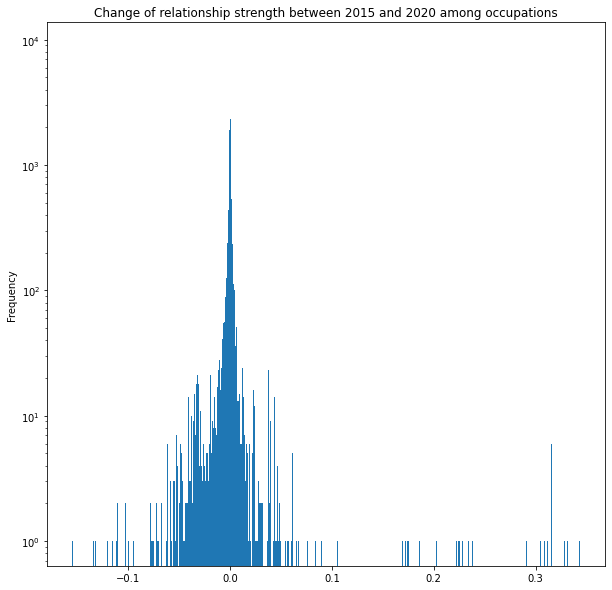

In [ ]:
import numpy as np
# read json graphs (2015-2020) --- LINKS

for idx, year in enumerate(range(2015, 2021)):
    graph_path = r"/content/drive/MyDrive/json_graphs/graph_occupation" + str(year) + ".json"
    G = read_json_graph(graph_path)
    data_nodes = ntx.json_graph.node_link_data(G)
    
    if idx == 0:
        df_nodes = pd.DataFrame(data_nodes['links'])
        df_nodes['weight'] = (df_nodes['weight'] / np.sum(df_nodes['weight']))*100 # absolute to relative values
        df_nodes = df_nodes.reindex(columns=['id','source','target','weight']) # need to reorder
    else:
        df2 = pd.DataFrame(data_nodes['links'])
        df2['weight'] = (df2['weight'] / np.sum(df2['weight']))*100
        df_nodes = pd.merge(df_nodes, df2, how='inner', on=['id','source','target'], suffixes=(str(year-1), str(year)))
    
# check difference between first and last year
df_nodes['weight_dif'] = df_nodes['weight2020'] - df_nodes['weight2015']

# reorder
df_nodes = df_nodes.sort_values('weight_dif')

# plot distribution
df_nodes['weight_dif'].plot(kind='hist', xlabel='Weight difference',ylabel='log(Frequency)', logy=True,
                             title='Change of relationship strength between 2015 and 2020 among occupations', bins=1000, figsize=(10,10))

Here we select the connections with highest increase and decrease between 2015 and 2020. We use a time-series plot to visualize the observed trend over time, although it is not representative towards the whole data, since the majority have close to zero change, these are more likely to be highlights.


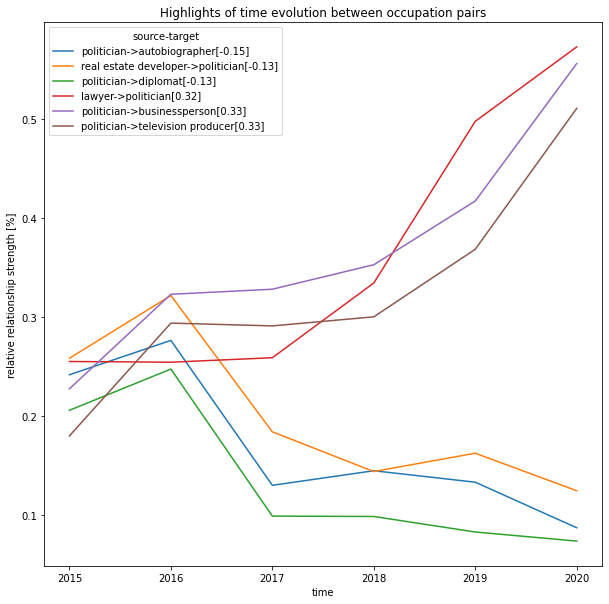

In [ ]:
# select best and worst occupations
df_toPlot = df_nodes[0:3].append(df_nodes[-4:-1])

# remove unnecessary coloumns
df_toPlot['source-target'] = df_toPlot['source'] + '->' + df_toPlot['target'] +'[' + round(df_toPlot['weight_dif'],2).astype(str) + ']'
df_toPlot = df_toPlot[df_toPlot.columns.drop(['id','source','target','weight_dif'])]

# reshape dataframe
df_toPlot['source-target'] = df_toPlot['source-target']
df_toPlot.index = df_toPlot['source-target']
df_toPlot = df_toPlot.drop(columns='source-target')
df_toPlot = df_toPlot.transpose()
df_toPlot.index = df_toPlot.index.str.replace('weight','')

# plot
df_toPlot.plot(xlabel = 'time', ylabel = 'relative relationship strength [%]', title='Highlights of time evolution between occupation pairs', figsize=(10,10))

# Networks analysis
Now that we've got some ready-to-use relationships networks, we'd like to perform some network-specific analysis.

In [7]:
years = ['2015', '2016', '2017', '2018', '2019', '2020']
nets_occ = [read_json_graph(f'/content/drive/MyDrive/relationships_graphs/graph_occupation{year}.json')
        for year in years
]
nets_occgen = [read_json_graph(f'/content/drive/MyDrive/relationships_graphs/graph_occupation_gender{year}.json')
        for year in years
]

In [8]:
import seaborn as sns
from collections import defaultdict
sns.set_theme()
figures_dir = '/content/drive/MyDrive/figures/'

To begin with, the Node degree distribution can give us an idea of the network's density:

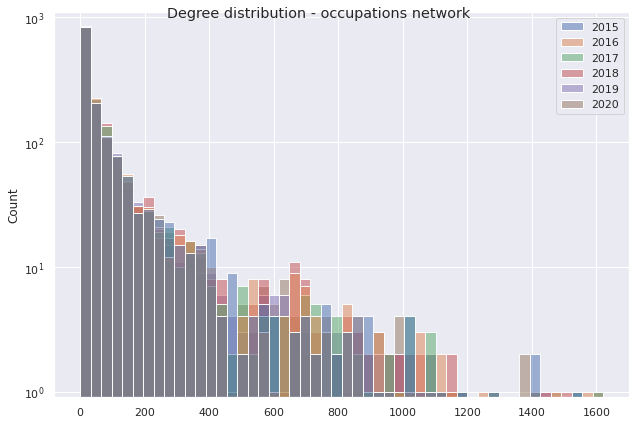

In [9]:
degrees = {year: [deg for node, deg in net.degree] for year, net in zip(years, nets_occ)}
plt.figure(figsize=(9, 6), tight_layout=True)
sns.histplot(degrees, log_scale=(None, 10), bins=50)
plt.suptitle("Degree distribution - occupations network")
plt.ylim(0.9, 1.1e3)
plt.savefig(figures_dir + "degree_distrib_occ.png")
plt.show()

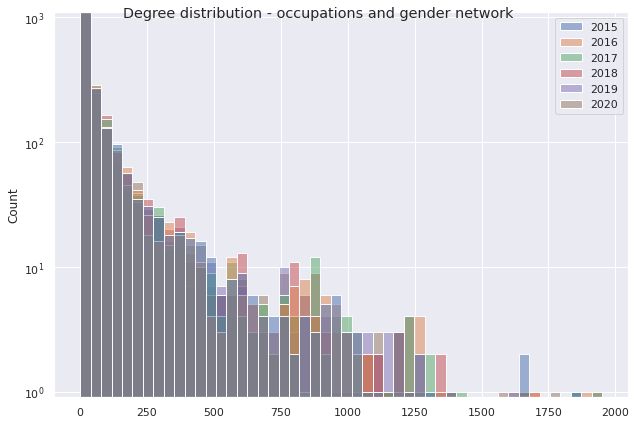

In [10]:
degrees = {year: [deg for node, deg in net.degree] for year, net in zip(years, nets_occgen)}
plt.figure(figsize=(9, 6), tight_layout=True)
sns.histplot(degrees, log_scale=(None, 10), bins=50)
plt.suptitle("Degree distribution - occupations and gender network")
plt.ylim(0.9, 1.1e3)
plt.savefig(figures_dir + "degree_distrib_occgen.png")
plt.show()

Those distributions are **heavily** skewed, far from the usual real-world network. This means that the graphs are almost complete, which implies that a lot of preprocessing will be needed before it can be visualized. Moreover the very presence of an edge between two nodes thus does not represent very valuable information. That's why we'll need to deal with the **weights** of the edges rather than the facts that they exist.

We now define the **interest** of an occupation $A$ in an occupation $B$ by the proportion of the quotations whose speaker is $A$ where the subject is $B$. Said in a more natural manner, the interest reflects the probability that *when $A$ talks, it's about $B$*. Being a proportion, the interest is between $0$ and $1$.

We'll now explore which occupations are the "most interesting", with different meanings for "most". We're gonna need some ugly functions first:

In [11]:
def compute_edge_weights(net):
    """
    Computes the weight of each edge in a network. The weight of A->B
    is defined as the proportion of mentions of speaker A whose subject
    is B.
    :param net: NetworkX graph
    :return: a dictionnary of dictionnaries D. D[A][B] returns the
        weight of edge A->B.
    """
    edge_weights = dict()
    for node in net.nodes:
        edge_weights[node] = defaultdict(float)
        total_outweight = 0
        # Stores the weight of each outgoing edge in edge_weights, and computes
        # their total weight
        for succ in net.successors(node):
            edge_weights[node][succ] = net.get_edge_data(node, succ)['weight']
            total_outweight += edge_weights[node][succ]
        # Divides all weights by their sum so that they sum to 1 and represent
        # proportions
        for succ in net.successors(node):
            edge_weights[node][succ] = edge_weights[node][succ] / total_outweight
    return edge_weights


def inweights(net, edges_weights, avg=False):
    """
    Computes the sum of the weights of the edges incoming
    to every node of a network.
    :param net: networkx graph
    :param edges_weights: weights of the edges for 'net',
        computed by compute_edge_weights.
    :param avg: boolean. If True, averages the weights instead
        of summing them.
    """
    inweights = defaultdict(float)
    for node in net.nodes:
        inweights[node] = sum((edges_weights[p][node] for p in net.predecessors(node)))
        if avg:
            inweights[node] = inweights[node] / max(len(list(net.predecessors(node))), 1)
    return inweights


def avg_dicts(dicts):
    """
    Computes the average of a list of dictionnaries: if
    'a' is in dicts D1 and D2, then
        (D1 + D2)['a'] = (D1['a'] + D2['a']) / 2
    If 'a' is only in D1, then
        (D1 + D2)['a'] = D1['a'] / 2
    :param dicts: list of dictionnaries 'key':float
    :return: a dictionnary D such that D is the sum
        of dicts.
    """
    d_sum = defaultdict(float)
    for dict_ in dicts:
        for key, value in dict_.items():
            d_sum[key] += value / len(dicts)
    return d_sum

Fiiiinally ! We can now plot the **total interest** of the occupations: if we sum all of the interest of all occupations in all other occupations, which ones get the highest scores ?

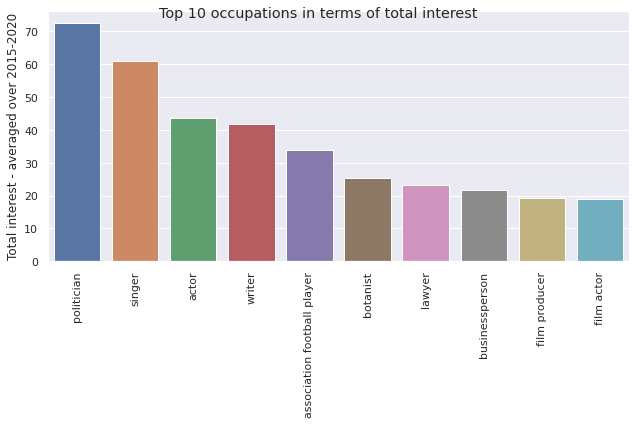

In [14]:
nets_edges_weights = [compute_edge_weights(net) for net in nets_occ]
inweights_by_year = [inweights(net, ew, avg=False) for net, ew in zip(nets_occ, nets_edges_weights)]
inweights_avg = avg_dicts(inweights_by_year)
top10_interest = pd.Series(inweights_avg).sort_values(ascending=False)[:10]

plt.figure(figsize=(9, 6), tight_layout=True)
sns.barplot(x=top10_interest.index, y=top10_interest)
plt.xticks(np.arange(10), top10_interest.index, rotation=90)
plt.suptitle("Top 10 occupations in terms of total interest")
plt.ylabel('Total interest - averaged over 2015-2020')
plt.savefig(figures_dir + "sum_interests_occ.png")
plt.show()

Politicians ! What a surprise ! This list can be interpreted as "the occupations that the population talks the most about overall". However, we can be interested in the **average interest**: if we take a single occupation $A$, how much do the other occupations care about $A$ *on average* ?

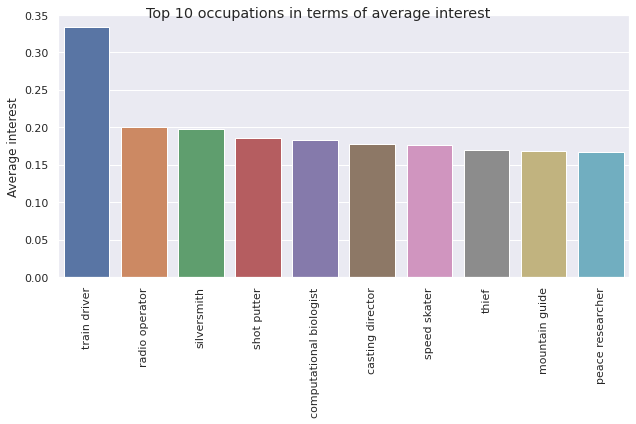

In [15]:
inweights_by_year = [inweights(net, ew, avg=True) for net, ew in zip(nets_occ, nets_edges_weights)]
inweights_avg = avg_dicts(inweights_by_year)
avg_interests = pd.Series(inweights_avg).sort_values(ascending=False)
top10_avg = avg_interests[:10]

plt.figure(figsize=(9, 6), tight_layout=True)
sns.barplot(x=top10_avg.index, y=top10_avg)
plt.xticks(np.arange(10), top10_avg.index, rotation=90)
plt.suptitle("Top 10 occupations in terms of average interest")
plt.ylabel('Average interest')
plt.savefig(figures_dir + "avg_interests_occ.png")
plt.show()

Well well well ! No politicians, singers or actors anymore. We now obtain some veery specific occupations. But then, how much do people care about the 'most famous' occupations on average ?

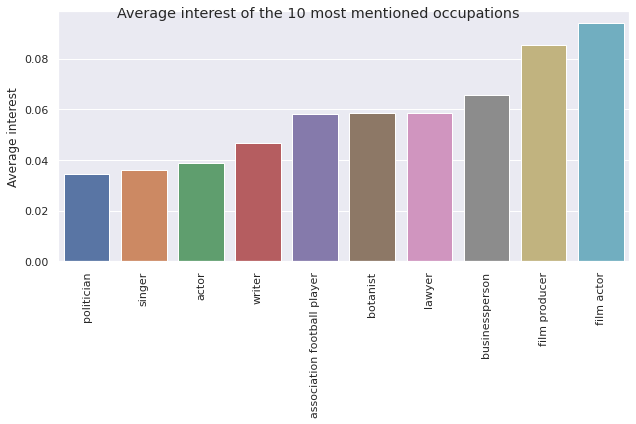

In [16]:
avg_int_giants = pd.Series({occ: avg_interests[occ] for occ in top10_interest.index})

plt.figure(figsize=(9, 6), tight_layout=True)
sns.barplot(x=avg_int_giants, y=avg_int_giants)
plt.xticks(np.arange(10), avg_int_giants.index, rotation=90)
plt.suptitle("Average interest of the 10 most mentioned occupations")
plt.ylabel('Average interest')
plt.savefig(figures_dir + "avg_interests_giants.png")
plt.show()

Although this barchart seems sorted, it was not meant to be. It appears that the average interest of the occupations in 'politician' is a little under 4%.  

**Conclusion:**
Let's say you're any occupation. On average, you will mention a politician 4% of the times you mention someone. Besides, there's most likely another rather specific occupation linked to yours, which you will talk about more often (perhaps train driver or speed skater).

However pretty much everyone talks about politicians, while you might be the only one to mention skate drivers. Thus (and as expected !) the politicians get more attention if you consider the whole social environment as a whole.